In [ ]:
# Cell 1: Imports and Seed Initialization

import os
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("reda1451/respiratorydatabase")
print("Path to dataset files:", path)

100%|██████████| 73.8M/73.8M [00:00<00:00, 195MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/reda1451/respiratorydatabase/versions/1


In [ ]:
# Cell 2: Dataset Paths and Hyperparameters

dataset_path = "/root/.cache/kagglehub/datasets/reda1451/respiratorydatabase/versions/1/RespiratoryDatabase@TR"
labels_path = "/root/.cache/kagglehub/datasets/reda1451/respiratorydatabase/versions/1/Labels.xlsx"

window_duration = 2.0
overlap = 0.5
n_mels = 64
n_fft = 1024
hop_length = 512
fmin = 20

batch_size = 32
lr = 0.001
weight_decay = 1e-4
num_epochs = 200
patience = 15
d_z = 64

In [ ]:

import os

# Dataset directory
dataset_path = "/root/.cache/kagglehub/datasets/reda1451/respiratorydatabase/versions/1/RespiratoryDatabase@TR"

# Initialize subject_files dictionary
subject_files = {}

# Parse all .wav files directly from folder
if os.path.exists(dataset_path):
    for file in os.listdir(dataset_path):
        if file.lower().endswith(".wav"):
            # Extract subject ID from filename (first 4 chars like H001)
            subject_id = file[:4]
            file_path = os.path.join(dataset_path, file)

            if subject_id not in subject_files:
                subject_files[subject_id] = []
            subject_files[subject_id].append(file_path)

print("Total subjects with .wav files:", len(subject_files))

Total subjects with .wav files: 42


In [ ]:
print(len(subject_files))

42


In [ ]:
# Cell 4: Step 2 — Read and Parse Label File

print("Step 2: Parsing labels...")
labels_df = pd.read_excel(labels_path)
subject_labels = {}

for _, row in labels_df.iterrows():
    patient_id = str(row['Patient ID'])
    diagnosis = str(row['Diagnosis'])
    if diagnosis.startswith('COPD'):
        severity = int(diagnosis.replace('COPD', ''))
        subject_labels[patient_id] = severity

print(f"Found labels for {len(subject_labels)} subjects")

Step 2: Parsing labels...
Found labels for 42 subjects


In [ ]:
print(subject_labels)

{'H002': 4, 'H003': 4, 'H004': 4, 'H005': 4, 'H006': 4, 'H007': 3, 'H008': 3, 'H009': 4, 'H010': 3, 'H011': 4, 'H012': 4, 'H013': 4, 'H014': 4, 'H015': 4, 'H016': 0, 'H017': 1, 'H018': 2, 'H021': 0, 'H022': 4, 'H023': 4, 'H024': 4, 'H025': 4, 'H026': 3, 'H028': 2, 'H029': 1, 'H030': 2, 'H031': 2, 'H032': 4, 'H033': 3, 'H034': 3, 'H035': 4, 'H036': 3, 'H037': 0, 'H038': 2, 'H039': 1, 'H040': 0, 'H041': 0, 'H042': 2, 'H043': 1, 'H044': 2, 'H045': 1, 'H050': 0}


In [ ]:
# Cell 5: Step 3 — Split Subjects into Healthy and Diseased

healthy_subject_ids = []
diseased_subject_ids = []

for subject_id, label in subject_labels.items():
    if subject_id in subject_files:
        if label == 0:
            healthy_subject_ids.append(subject_id)
        else:
            diseased_subject_ids.append(subject_id)

print(f"Healthy subjects: {len(healthy_subject_ids)}")
print(f"Diseased subjects: {len(diseased_subject_ids)}")

Healthy subjects: 6
Diseased subjects: 36


In [ ]:
# Cell 6: Step 6 — Processing Audio Files into Windows (Flattened)

print("Step 6: Processing audio files into windows...")
all_windows = []

for subject_id in tqdm(list(subject_files.keys()), desc="Processing subjects"):
    file_paths = subject_files[subject_id]

    # Group files by side (L1-L6 for left, R1-R6 for right)
    left_files = [f for f in file_paths if '_L' in f]
    right_files = [f for f in file_paths if '_R' in f]

    for side_files, side_name in [(left_files, 'L'), (right_files, 'R')]:
        if len(side_files) < 6:
            continue

        side_files.sort(key=lambda x: int(x.split('_')[1][1:].split('.')[0]))

        # Load all channels for this side
        channel_waveforms = []
        sr = None

        for file_path in side_files[:6]:
            try:
                waveform, file_sr = librosa.load(file_path, sr=None)
                waveform = (waveform - np.mean(waveform)) / (np.std(waveform) + 1e-8)
                channel_waveforms.append(waveform)
                if sr is None:
                    sr = file_sr
            except:
                continue

        if len(channel_waveforms) < 6:
            continue

        min_length = min(len(w) for w in channel_waveforms)
        channel_waveforms = [w[:min_length] for w in channel_waveforms]

        n_win = int(window_duration * sr)
        step = int(n_win * (1 - overlap))
        num_windows = (min_length - n_win) // step + 1

        for window_idx in range(num_windows):
            start_idx = window_idx * step
            end_idx = start_idx + n_win
            if end_idx > min_length:
                break

            window_melspecs = []
            for channel_waveform in channel_waveforms:
                window_chunk = channel_waveform[start_idx:end_idx]
                mel_spec = librosa.feature.melspectrogram(
                    y=window_chunk, sr=sr, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length, fmin=fmin, fmax=sr // 2
                )
                mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
                window_melspecs.append(mel_spec_db)

            multi_channel_window = np.stack(window_melspecs, axis=0)
            all_windows.append((multi_channel_window, subject_id, f"{side_name}_{window_idx}"))

print(f"Created {len(all_windows)} windows total")

Step 6: Processing audio files into windows...


Processing subjects: 100%|██████████| 42/42 [00:30<00:00,  1.37it/s]

Created 1530 windows total


In [ ]:
# Cell 7: Step 7 — Build Healthy and Diseased Window Datasets

healthy_windows = []
diseased_windows = []

for window_data, subject_id, window_id in all_windows:
    if subject_id in healthy_subject_ids:
        healthy_windows.append(window_data)
    elif subject_id in diseased_subject_ids:
        diseased_windows.append(window_data)

print(f"Healthy windows: {len(healthy_windows)}")
print(f"Diseased windows: {len(diseased_windows)}")

Healthy windows: 229
Diseased windows: 1301


In [ ]:
# Cell 8: Step 8 — Compute Normalization Statistics and Normalize Windows

print("Step 8: Computing normalization statistics...")
if len(healthy_windows) > 0:
    healthy_stack = np.stack(healthy_windows, axis=0)  # Shape: (N, 6, n_mels, T)

    channel_stats = {}
    for ch in range(6):
        channel_data = healthy_stack[:, ch, :, :]
        mean_val = np.mean(channel_data)
        std_val = np.std(channel_data)
        channel_stats[ch] = (mean_val, std_val)

    def normalize_window(window):
        normalized = np.zeros_like(window)
        for ch in range(min(6, window.shape[0])):
            mean_val, std_val = channel_stats[ch]
            normalized[ch] = (window[ch] - mean_val) / (std_val + 1e-8)
        return normalized

    healthy_windows_norm = [normalize_window(w) for w in healthy_windows]
    diseased_windows_norm = [normalize_window(w) for w in diseased_windows]

    print("Normalization completed")
else:
    healthy_windows_norm = healthy_windows
    diseased_windows_norm = diseased_windows

Step 8: Computing normalization statistics...
Normalization completed


In [ ]:
# Cell 9: Step 9 — PyTorch Dataset Class for Healthy Windows

class HealthyWindowDataset(Dataset):
    def __init__(self, windows_list):
        self.windows = windows_list

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window = self.windows[idx]
        return torch.FloatTensor(window)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeepCNNAutoencoder(nn.Module):
    def __init__(self, input_channels=6, d_z=64):
        super(DeepCNNAutoencoder, self).__init__()

        # Encoder: 4 convolutional blocks
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.flatten_size = None
        self.encoder_fc = None
        self.decoder_fc = None

        # Decoder transpose-convolutions: mirror of encoder
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        batch_size, channels, H_e, W_e = encoded.shape
        encoded_flat = encoded.view(batch_size, -1)

        if self.flatten_size is None or encoded_flat.size(1) != self.flatten_size:
            self.flatten_size = encoded_flat.size(1)
            self.encoder_fc = nn.Linear(self.flatten_size, d_z).to(x.device)
            self.decoder_fc = nn.Linear(d_z, self.flatten_size).to(x.device)

        z = self.encoder_fc(encoded_flat)
        decoded_flat = self.decoder_fc(z)
        decoded_reshaped = decoded_flat.view(batch_size, channels, H_e, W_e)
        reconstructed = self.decoder_conv(decoded_reshaped)

        if reconstructed.size(2) != x.size(2) or reconstructed.size(3) != x.size(3):
            reconstructed = F.interpolate(reconstructed, size=(x.size(2), x.size(3)))

        return reconstructed

In [ ]:
# Cell 11: Step 11 — Weight Initialization Function

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:
# Cell 12: Step 12 — Split Healthy Windows into Train/Validation

if len(healthy_windows_norm) > 0:
    train_windows, val_windows = train_test_split(
        healthy_windows_norm, test_size=0.2, random_state=42
    )
    print(f"Train windows: {len(train_windows)}")
    print(f"Validation windows: {len(val_windows)}")
else:
    print("No healthy windows available for training")
    train_windows, val_windows = [], []

Train windows: 183
Validation windows: 46


In [ ]:
# Cell 13: Step 13 — Create DataLoaders

if len(train_windows) > 0:
    train_dataset = HealthyWindowDataset(train_windows)
    val_dataset = HealthyWindowDataset(val_windows)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print("DataLoaders created")
else:
    train_loader = None
    val_loader = None

DataLoaders created


In [ ]:
# Cell 14: Step 14 — Train the Autoencoder

if train_loader is not None and val_loader is not None:
    print("Step 14: Training autoencoder...")

    # Corrected the class name from CNNAutoencoder to DeepCNNAutoencoder
    autoencoder = DeepCNNAutoencoder(input_channels=6, d_z=d_z).to(device)
    autoencoder.apply(init_weights)

    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.L1Loss()

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    checkpoint_path = 'autoencoder_checkpoint.pth'

    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        val_losses = checkpoint['val_losses']
        best_val_loss = checkpoint['best_val_loss']
        patience_counter = checkpoint['patience_counter']
        print(f"Resumed from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        autoencoder.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for batch_x in train_pbar:
            batch_x = batch_x.to(device)
            optimizer.zero_grad()
            reconstructed = autoencoder(batch_x)
            loss = criterion(reconstructed, batch_x)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_pbar.set_postfix({'loss': f'{loss.item(): .6f}'})

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        autoencoder.eval()
        val_loss = 0.0
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')

        with torch.no_grad():
            for batch_x in val_pbar:
                batch_x = batch_x.to(device)
                reconstructed = autoencoder(batch_x)
                loss = criterion(reconstructed, batch_x)
                val_loss += loss.item()
                val_pbar.set_postfix({'loss': f'{loss.item(): .6f}'})

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

        checkpoint = {
            'epoch': epoch,
            'model_state_dict': autoencoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter
        }
        torch.save(checkpoint, checkpoint_path)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(autoencoder.state_dict(), 'best_autoencoder.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch+1} epochs')
            break

    print("Training completed!")
    autoencoder.load_state_dict(torch.load('best_autoencoder.pth', map_location=device))
    print("Best model loaded")

Step 14: Training autoencoder...


Epoch 1/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 16.12it/s, loss=0.852806]


Epoch 1: Train Loss: 0.812234, Val Loss: 0.846003


Epoch 2/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.94it/s, loss=0.763498]


Epoch 2: Train Loss: 0.667890, Val Loss: 0.758578


Epoch 3/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.44it/s, loss=0.574343]


Epoch 3: Train Loss: 0.561052, Val Loss: 0.574008


Epoch 4/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.76it/s, loss=0.447651]


Epoch 4: Train Loss: 0.476406, Val Loss: 0.448659


Epoch 5/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 19.85it/s, loss=0.384836]


Epoch 5: Train Loss: 0.421808, Val Loss: 0.386602


Epoch 6/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.70it/s, loss=0.355568]


Epoch 6: Train Loss: 0.387147, Val Loss: 0.358320


Epoch 7/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.38it/s, loss=0.341029]


Epoch 7: Train Loss: 0.365027, Val Loss: 0.343910


Epoch 8/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.47it/s, loss=0.334417]


Epoch 8: Train Loss: 0.349453, Val Loss: 0.336900


Epoch 9/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 23.49it/s, loss=0.335494]


Epoch 9: Train Loss: 0.340342, Val Loss: 0.337494


Epoch 10/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.53it/s, loss=0.337697]


Epoch 10: Train Loss: 0.332159, Val Loss: 0.339480


Epoch 11/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.76it/s, loss=0.336763]


Epoch 11: Train Loss: 0.327000, Val Loss: 0.338060


Epoch 12/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.15it/s, loss=0.332487]


Epoch 12: Train Loss: 0.321259, Val Loss: 0.333096


Epoch 13/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.32it/s, loss=0.336011]


Epoch 13: Train Loss: 0.319067, Val Loss: 0.336263


Epoch 14/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 20.85it/s, loss=0.314163]


Epoch 14: Train Loss: 0.318212, Val Loss: 0.314870


Epoch 15/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.80it/s, loss=0.317184]


Epoch 15: Train Loss: 0.313925, Val Loss: 0.317619


Epoch 16/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 23.16it/s, loss=0.314433]


Epoch 16: Train Loss: 0.313500, Val Loss: 0.315307


Epoch 17/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.97it/s, loss=0.315846]


Epoch 17: Train Loss: 0.312301, Val Loss: 0.315819


Epoch 18/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.67it/s, loss=0.317448]


Epoch 18: Train Loss: 0.308860, Val Loss: 0.317985


Epoch 19/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.64it/s, loss=0.314451]


Epoch 19: Train Loss: 0.306896, Val Loss: 0.314874


Epoch 20/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 19.73it/s, loss=0.319663]


Epoch 20: Train Loss: 0.306277, Val Loss: 0.320077


Epoch 21/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.25it/s, loss=0.313909]


Epoch 21: Train Loss: 0.305894, Val Loss: 0.313473


Epoch 22/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 15.41it/s, loss=0.318511]


Epoch 22: Train Loss: 0.304217, Val Loss: 0.318214


Epoch 23/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 11.55it/s, loss=0.307710]


Epoch 23: Train Loss: 0.302342, Val Loss: 0.307181


Epoch 24/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 15.14it/s, loss=0.316210]


Epoch 24: Train Loss: 0.300279, Val Loss: 0.314555


Epoch 25/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 14.85it/s, loss=0.309629]


Epoch 25: Train Loss: 0.299324, Val Loss: 0.307619


Epoch 26/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 12.87it/s, loss=0.318565]


Epoch 26: Train Loss: 0.298137, Val Loss: 0.314709


Epoch 27/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 14.71it/s, loss=0.310733]


Epoch 27: Train Loss: 0.295090, Val Loss: 0.307953


Epoch 28/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.39it/s, loss=0.308800]


Epoch 28: Train Loss: 0.292647, Val Loss: 0.305098


Epoch 29/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.63it/s, loss=0.307478]


Epoch 29: Train Loss: 0.292547, Val Loss: 0.304228


Epoch 30/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 23.03it/s, loss=0.304098]


Epoch 30: Train Loss: 0.291263, Val Loss: 0.299596


Epoch 31/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 20.83it/s, loss=0.300527]


Epoch 31: Train Loss: 0.288213, Val Loss: 0.295850


Epoch 32/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 20.18it/s, loss=0.302396]


Epoch 32: Train Loss: 0.286614, Val Loss: 0.297504


Epoch 33/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.68it/s, loss=0.300197]


Epoch 33: Train Loss: 0.284755, Val Loss: 0.295158


Epoch 34/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.22it/s, loss=0.302463]


Epoch 34: Train Loss: 0.285630, Val Loss: 0.297222


Epoch 35/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.79it/s, loss=0.309876]


Epoch 35: Train Loss: 0.284635, Val Loss: 0.303694


Epoch 36/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 17.79it/s, loss=0.299161]


Epoch 36: Train Loss: 0.285666, Val Loss: 0.293234


Epoch 37/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.05it/s, loss=0.303812]


Epoch 37: Train Loss: 0.282955, Val Loss: 0.298125


Epoch 38/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.51it/s, loss=0.303104]


Epoch 38: Train Loss: 0.281614, Val Loss: 0.297612


Epoch 39/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.20it/s, loss=0.300410]


Epoch 39: Train Loss: 0.279148, Val Loss: 0.293826


Epoch 40/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.07it/s, loss=0.301664]


Epoch 40: Train Loss: 0.278913, Val Loss: 0.295294


Epoch 41/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.77it/s, loss=0.301912]


Epoch 41: Train Loss: 0.280551, Val Loss: 0.295062


Epoch 42/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.08it/s, loss=0.295037]


Epoch 42: Train Loss: 0.279056, Val Loss: 0.289188


Epoch 43/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.28it/s, loss=0.294708]


Epoch 43: Train Loss: 0.279059, Val Loss: 0.288754


Epoch 44/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.05it/s, loss=0.295125]


Epoch 44: Train Loss: 0.278543, Val Loss: 0.288762


Epoch 45/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.80it/s, loss=0.299839]


Epoch 45: Train Loss: 0.276908, Val Loss: 0.293982


Epoch 46/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 23.09it/s, loss=0.295599]


Epoch 46: Train Loss: 0.276373, Val Loss: 0.288646


Epoch 47/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 20.78it/s, loss=0.301949]


Epoch 47: Train Loss: 0.276824, Val Loss: 0.294945


Epoch 48/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 23.03it/s, loss=0.295578]


Epoch 48: Train Loss: 0.277193, Val Loss: 0.288581


Epoch 49/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 23.03it/s, loss=0.295498]


Epoch 49: Train Loss: 0.275488, Val Loss: 0.289511


Epoch 50/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.79it/s, loss=0.294222]


Epoch 50: Train Loss: 0.274735, Val Loss: 0.287448


Epoch 51/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 18.25it/s, loss=0.294586]


Epoch 51: Train Loss: 0.273716, Val Loss: 0.287813


Epoch 52/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 23.67it/s, loss=0.296564]


Epoch 52: Train Loss: 0.272355, Val Loss: 0.289608


Epoch 53/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 23.39it/s, loss=0.293644]


Epoch 53: Train Loss: 0.270213, Val Loss: 0.286697


Epoch 54/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.13it/s, loss=0.292860]


Epoch 54: Train Loss: 0.269846, Val Loss: 0.286281


Epoch 55/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.94it/s, loss=0.291491]


Epoch 55: Train Loss: 0.270139, Val Loss: 0.285023


Epoch 56/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.64it/s, loss=0.292092]


Epoch 56: Train Loss: 0.270727, Val Loss: 0.285233


Epoch 57/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.36it/s, loss=0.292335]


Epoch 57: Train Loss: 0.267312, Val Loss: 0.285403


Epoch 58/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.03it/s, loss=0.290371]


Epoch 58: Train Loss: 0.267624, Val Loss: 0.283619


Epoch 59/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.76it/s, loss=0.293682]


Epoch 59: Train Loss: 0.265942, Val Loss: 0.287013


Epoch 60/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 23.17it/s, loss=0.294352]


Epoch 60: Train Loss: 0.266554, Val Loss: 0.287796


Epoch 61/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.59it/s, loss=0.293504]


Epoch 61: Train Loss: 0.265924, Val Loss: 0.286580


Epoch 62/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 19.74it/s, loss=0.293612]


Epoch 62: Train Loss: 0.266844, Val Loss: 0.286212


Epoch 63/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.10it/s, loss=0.290539]


Epoch 63: Train Loss: 0.264497, Val Loss: 0.284101


Epoch 64/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s, loss=0.291969]


Epoch 64: Train Loss: 0.264010, Val Loss: 0.285263


Epoch 65/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 13.67it/s, loss=0.289469]


Epoch 65: Train Loss: 0.264087, Val Loss: 0.283170


Epoch 66/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 14.74it/s, loss=0.285080]


Epoch 66: Train Loss: 0.263133, Val Loss: 0.279103


Epoch 67/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 13.67it/s, loss=0.287425]


Epoch 67: Train Loss: 0.263098, Val Loss: 0.280785


Epoch 68/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 14.16it/s, loss=0.288326]


Epoch 68: Train Loss: 0.261960, Val Loss: 0.281498


Epoch 69/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 14.25it/s, loss=0.292971]


Epoch 69: Train Loss: 0.263199, Val Loss: 0.286615


Epoch 70/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 17.98it/s, loss=0.289459]


Epoch 70: Train Loss: 0.260933, Val Loss: 0.282867


Epoch 71/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.43it/s, loss=0.284924]


Epoch 71: Train Loss: 0.260097, Val Loss: 0.278302


Epoch 72/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.43it/s, loss=0.285305]


Epoch 72: Train Loss: 0.260979, Val Loss: 0.279235


Epoch 73/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.33it/s, loss=0.287640]


Epoch 73: Train Loss: 0.259156, Val Loss: 0.280760


Epoch 74/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.19it/s, loss=0.282953]


Epoch 74: Train Loss: 0.259401, Val Loss: 0.276998


Epoch 75/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.66it/s, loss=0.282517]


Epoch 75: Train Loss: 0.257844, Val Loss: 0.276601


Epoch 76/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.26it/s, loss=0.283917]


Epoch 76: Train Loss: 0.257684, Val Loss: 0.277781


Epoch 77/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.72it/s, loss=0.281397]


Epoch 77: Train Loss: 0.257775, Val Loss: 0.275691


Epoch 78/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.64it/s, loss=0.282827]


Epoch 78: Train Loss: 0.257035, Val Loss: 0.276351


Epoch 79/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.44it/s, loss=0.283490]


Epoch 79: Train Loss: 0.257675, Val Loss: 0.277321


Epoch 80/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.28it/s, loss=0.283754]


Epoch 80: Train Loss: 0.255187, Val Loss: 0.277989


Epoch 81/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 19.16it/s, loss=0.282041]


Epoch 81: Train Loss: 0.254210, Val Loss: 0.275983


Epoch 82/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.49it/s, loss=0.280105]


Epoch 82: Train Loss: 0.253501, Val Loss: 0.274219


Epoch 83/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.29it/s, loss=0.284408]


Epoch 83: Train Loss: 0.253310, Val Loss: 0.278383


Epoch 84/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.21it/s, loss=0.280761]


Epoch 84: Train Loss: 0.251790, Val Loss: 0.274277


Epoch 85/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.63it/s, loss=0.279405]


Epoch 85: Train Loss: 0.250306, Val Loss: 0.273840


Epoch 86/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.73it/s, loss=0.278416]


Epoch 86: Train Loss: 0.249678, Val Loss: 0.272885


Epoch 87/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.08it/s, loss=0.281503]


Epoch 87: Train Loss: 0.249239, Val Loss: 0.274706


Epoch 88/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.11it/s, loss=0.282695]


Epoch 88: Train Loss: 0.249586, Val Loss: 0.276083


Epoch 89/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.86it/s, loss=0.278190]


Epoch 89: Train Loss: 0.249357, Val Loss: 0.272843


Epoch 90/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 20.64it/s, loss=0.280491]


Epoch 90: Train Loss: 0.249970, Val Loss: 0.274483


Epoch 91/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.68it/s, loss=0.279430]


Epoch 91: Train Loss: 0.250580, Val Loss: 0.273649


Epoch 92/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 19.52it/s, loss=0.281662]


Epoch 92: Train Loss: 0.247478, Val Loss: 0.275537


Epoch 93/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.26it/s, loss=0.279844]


Epoch 93: Train Loss: 0.245823, Val Loss: 0.273984


Epoch 94/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.00it/s, loss=0.277015]


Epoch 94: Train Loss: 0.245568, Val Loss: 0.271356


Epoch 95/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.50it/s, loss=0.279049]


Epoch 95: Train Loss: 0.246730, Val Loss: 0.273407


Epoch 96/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 20.73it/s, loss=0.280872]


Epoch 96: Train Loss: 0.243703, Val Loss: 0.274848


Epoch 97/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 20.89it/s, loss=0.278311]


Epoch 97: Train Loss: 0.244187, Val Loss: 0.272593


Epoch 98/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.07it/s, loss=0.279104]


Epoch 98: Train Loss: 0.243093, Val Loss: 0.272835


Epoch 99/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.68it/s, loss=0.278013]


Epoch 99: Train Loss: 0.241791, Val Loss: 0.272227


Epoch 100/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.62it/s, loss=0.276214]


Epoch 100: Train Loss: 0.242033, Val Loss: 0.270591


Epoch 101/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.27it/s, loss=0.279511]


Epoch 101: Train Loss: 0.241171, Val Loss: 0.273625


Epoch 102/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.45it/s, loss=0.283504]


Epoch 102: Train Loss: 0.240685, Val Loss: 0.276918


Epoch 103/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 19.26it/s, loss=0.276536]


Epoch 103: Train Loss: 0.241290, Val Loss: 0.270916


Epoch 104/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 20.52it/s, loss=0.277419]


Epoch 104: Train Loss: 0.240702, Val Loss: 0.271484


Epoch 105/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 19.79it/s, loss=0.277150]


Epoch 105: Train Loss: 0.239458, Val Loss: 0.270772


Epoch 106/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 14.52it/s, loss=0.274412]


Epoch 106: Train Loss: 0.239838, Val Loss: 0.269557


Epoch 107/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 13.68it/s, loss=0.279608]


Epoch 107: Train Loss: 0.239818, Val Loss: 0.273164


Epoch 108/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 14.19it/s, loss=0.283060]


Epoch 108: Train Loss: 0.239903, Val Loss: 0.276208


Epoch 109/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 13.65it/s, loss=0.276030]


Epoch 109: Train Loss: 0.239244, Val Loss: 0.270341


Epoch 110/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 11.95it/s, loss=0.275390]


Epoch 110: Train Loss: 0.238590, Val Loss: 0.269948


Epoch 111/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 15.23it/s, loss=0.276476]


Epoch 111: Train Loss: 0.238525, Val Loss: 0.270687


Epoch 112/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.65it/s, loss=0.275982]


Epoch 112: Train Loss: 0.237210, Val Loss: 0.270611


Epoch 113/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.42it/s, loss=0.275696]


Epoch 113: Train Loss: 0.236133, Val Loss: 0.269812


Epoch 114/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.27it/s, loss=0.276738]


Epoch 114: Train Loss: 0.236203, Val Loss: 0.271098


Epoch 115/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 18.05it/s, loss=0.276840]


Epoch 115: Train Loss: 0.236402, Val Loss: 0.271530


Epoch 116/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.95it/s, loss=0.279940]


Epoch 116: Train Loss: 0.235336, Val Loss: 0.273315


Epoch 117/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.11it/s, loss=0.277559]


Epoch 117: Train Loss: 0.235116, Val Loss: 0.271560


Epoch 118/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.45it/s, loss=0.277593]


Epoch 118: Train Loss: 0.233830, Val Loss: 0.271836


Epoch 119/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.91it/s, loss=0.277436]


Epoch 119: Train Loss: 0.233357, Val Loss: 0.271652


Epoch 120/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 22.15it/s, loss=0.275569]


Epoch 120: Train Loss: 0.231761, Val Loss: 0.270046


Epoch 121/200 [Val]: 100%|██████████| 2/2 [00:00<00:00, 21.64it/s, loss=0.276858]


Epoch 121: Train Loss: 0.234005, Val Loss: 0.270899
Early stopping triggered after 121 epochs
Training completed!
Best model loaded


In [ ]:
# Cell 15: Step 15 — Compute Reconstruction Errors Function

def compute_reconstruction_errors(model, windows_list, batch_size=32):
    model.eval()
    errors = []
    dataset = HealthyWindowDataset(windows_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch_x in tqdm(dataloader, desc="Computing errors"):
            batch_x = batch_x.to(device)
            reconstructed = model(batch_x)
            batch_errors = torch.mean(torch.abs(reconstructed - batch_x), dim=[1,2,3]).cpu().numpy()
            errors.extend(batch_errors)
    return np.array(errors)

In [ ]:
# Cell 16: Step 16 — Compute Threshold from Validation Healthy Windows

print("Step 16: Computing reconstruction error threshold...")
val_errors = compute_reconstruction_errors(autoencoder, val_windows)
T_win = np.quantile(val_errors, 0.95)
print(f"Window-level threshold T_win: {T_win:.6f}")

Step 16: Computing reconstruction error threshold...


Computing errors: 100%|██████████| 2/2 [00:00<00:00, 237.75it/s]

Window-level threshold T_win: 0.315310


In [ ]:
# Cell 17: Step 17 — Compute Anomaly Scores for All Windows

print("Step 17: Computing anomaly scores for all windows...")
all_window_errors = {}

healthy_errors = compute_reconstruction_errors(autoencoder, healthy_windows_norm)
for i, error in enumerate(healthy_errors):
    subject_id = [subj for subj in healthy_subject_ids if subj in subject_files][i % len(healthy_subject_ids)]
    window_key = f"{subject_id}_healthy_{i}"
    all_window_errors[window_key] = error

diseased_errors = compute_reconstruction_errors(autoencoder, diseased_windows_norm)
for i, error in enumerate(diseased_errors):
    subject_id = [subj for subj in diseased_subject_ids if subj in subject_files][i % len(diseased_subject_ids)]
    window_key = f"{subject_id}_diseased_{i}"
    all_window_errors[window_key] = error

Step 17: Computing anomaly scores for all windows...


Computing errors: 100%|██████████| 41/41 [00:00<00:00, 382.87it/s]


In [ ]:
# Cell 18: Step 18 — Aggregate Window-Level Errors to Subject-Level Scores

print("Step 18: Aggregating to subject-level scores...")
subject_scores = {}

for window_key, error in all_window_errors.items():
    subject_id = window_key.split('_')[0]
    if subject_id not in subject_scores:
        subject_scores[subject_id] = []
    subject_scores[subject_id].append(error)

subject_score_dict = {}
for subject_id, errors in subject_scores.items():
    subject_score_dict[subject_id] = np.max(errors)

print(f"Computed scores for {len(subject_score_dict)} subjects")

Step 18: Aggregating to subject-level scores...
Computed scores for 42 subjects


In [ ]:
print("Step 19: Computing subject-level threshold...")
healthy_subject_scores = [subject_score_dict[subj] for subj in healthy_subject_ids if subj in subject_score_dict]
T_subj = np.quantile(healthy_subject_scores, 0.95)
print(f"Subject-level threshold T_subj: {T_subj:.6f}")

Step 19: Computing subject-level threshold...
Subject-level threshold T_subj: 0.372265


In [ ]:
# Cell 20: Step 20 — Generate Final Predictions

print("Step 20: Generating final predictions...")
predictions = {}
for subject_id, score in subject_score_dict.items():
    predictions[subject_id] = 1 if score > T_subj else 0

Step 20: Generating final predictions...


Step 26: Evaluating performance...

=== EVALUATION RESULTS ===
Overall Accuracy: 0.9762
Sensitivity (Recall): 1.0000
Specificity: 0.8333
Confusion Matrix:
[[ 5  1]
 [ 0 36]]
Step 27: Creating visualizations...


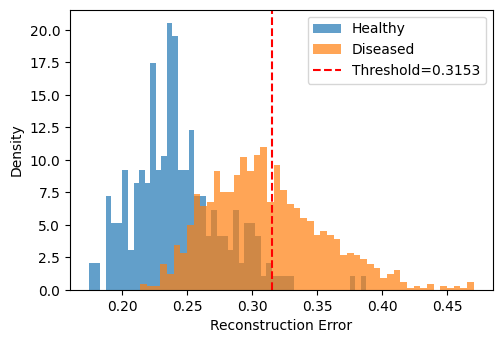

In [ ]:
# Cell 21: Step 26 — Evaluate Performance

print("Step 26: Evaluating performance...")
y_true = []
y_pred = []

for subject_id in predictions.keys():
    if subject_id in subject_labels:
        true_label = 0 if subject_labels[subject_id] == 0 else 1
        pred_label = predictions[subject_id]
        y_true.append(true_label)
        y_pred.append(pred_label)

if len(y_true) > 0:
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, len(y_true))
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print("\n=== EVALUATION RESULTS ===")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Sensitivity (Recall): {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    # Step 27: Plot Reconstruction Error Distributions
    print("Step 27: Creating visualizations...")
    plt.figure(figsize=(12, 8))

    # Plot 1: Error distributions
    plt.subplot(2, 2, 1)
    plt.hist(healthy_errors, bins=50, alpha=0.7, label='Healthy', density=True)
    plt.hist(diseased_errors, bins=50, alpha=0.7, label='Diseased', density=True)
    plt.axvline(T_win, color='red', linestyle='--', label=f'Threshold={T_win:.4f}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Density')
    plt.legend()

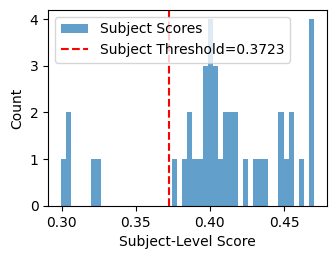

In [ ]:
# Cell 22: Step 27 — (Continued) Additional Plots if Needed

# You can add more plotting code here for further visualizations,
# such as subject-level score distributions, ROC curves, etc.
# For example:

plt.subplot(2, 2, 2)
plt.hist(list(subject_score_dict.values()), bins=50, alpha=0.7, label='Subject Scores')
plt.axvline(T_subj, color='red', linestyle='--', label=f'Subject Threshold={T_subj:.4f}')
plt.xlabel('Subject-Level Score')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

y_true_subj = [0 if subject_labels[s]==0 else 1 for s in subject_score_dict if s in subject_labels]
y_score_subj = [subject_score_dict[s] for s in subject_score_dict if s in subject_labels]

fpr, tpr, thresholds = roc_curve(y_true_subj, y_score_subj)
roc_auc = auc(fpr, tpr)
print("AUC:", roc_auc)

AUC: 0.9907407407407407


In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, pr_thresh = precision_recall_curve(y_true_subj, y_score_subj)
f1 = 2 * precision * recall / (precision + recall + 1e-8)
best = f1.argmax()
T_subj = pr_thresh[best]